In [14]:
from lbparticles import Precomputer, Particle, LogPotential, PotentialWrapper
import numpy as np
from lbparticles.util import VertOptionEnum
import random
from scipy.integrate import simpson
import matplotlib.pyplot as plt
import pickle

In [15]:
iHaveACopy=False
import urllib.request
lbprefn, headers = urllib.request.urlretrieve('https://www.dropbox.com/scl/fi/yo7ud56pxap10facsqk6k/big_10_1000_alpha2p2_lbpre.pickle?rlkey=dix9e1a5yn7gqjlw2sdtmfbnx&dl=1')
#lbpre = Precomputer.load(lbprefn)
iHaveACopy=True

In [16]:
def generate_particle(v_init, L):
    if iHaveACopy:
        #lbpre = Precomputer.load('../../big_10_1000_alpha2p2_lbpre.pickle') # adjust path to where you saved the pickle file.
        lbpre = Precomputer.load(lbprefn)
    else:
        lbpre = Precomputer() # Takes a bit of time to run.
        lbpre.save() # Save a copy
        
    G= 0.00449987
    r_obs = 8000.0
    xcart = [r_obs, 0, 0] 
    Vc = 204.4 # equivalent to 200 km/s

    nu0 = np.sqrt( 4.0*np.pi * G * 0.2) 
    alpha = 2.2 
    psir = PotentialWrapper(LogPotential(Vc), nur=lambda r:nu0*(r/8100.0)**(-alpha/2.0))

    # number of terms used in the series to find the tangential position of the particle
    ordershape = None
    # number of terms used in the series to find the relationship between the particle's phase in its radial oscillation and the current time.
    ordertime = 5 

    v_init_perpendicular = L / r_obs #value of the initial velocity perpendicular to the X-axis
    theta = random.uniform(0, 2*np.pi)

    # Compute component of initial velocity along X-axis
    if random.randint(0, 1):
        v_init_parallel = np.sqrt(v_init**2  -  v_init_perpendicular**2)
    else:
        v_init_parallel = -np.sqrt(v_init**2  -  v_init_perpendicular**2)

    xcart = [r_obs, 0, 0] 
    vcart = [v_init_parallel, v_init_perpendicular * np.sin(theta), v_init_perpendicular * np.cos(theta)]

    # initialize the particle
    part = Particle( xcart, vcart, psir, lbpre, ordershape=ordershape, ordertime=ordertime, zopt=VertOptionEnum.TILT)

    return part


In [17]:
def get_rho_star(Rs, zs):
    # Thin disk parameters
    Sigma_t = 816.6 # solar masses / pc^2
    z_t = 300 # pc
    R_t = 2900 # pc

    # Thick disk parameters
    Sigma_T = 209.5 # solar masses / pc^2
    z_T = 900 # pc
    R_T = 3310 # pc

    if np.any(Rs < 0):
        raise ValueError("One of the R values is negative. R should be non-negative")

    return Sigma_t / (2 * z_t) * np.exp(-np.abs(zs)/z_t - Rs/R_t)   +   Sigma_T / (2 * z_T) * np.exp(-np.abs(zs)/z_T - Rs/R_T) #Formula from McMillan's paper eqn (3). '_t' is thin disk. '_T' is thick disk.

def integrand_plus_z(times, part):
    Xs,Vs = part.xvabs(times)
    Rs = np.sqrt(Xs[:,0]**2 + Xs[:,1]**2) # this is the raidus in cylidrical coordinates of the MW
    print(Xs.shape)

    return get_rho_star(Rs, Xs[:,2]) * np.sqrt(Vs[:,0]**2 + Vs[:,1]**2 + Vs[:,2]**2), Xs[:,2], Rs

In [18]:
def past_disk_crossings(v_init, L):
    part = generate_particle(v_init, L)

    hubble_time = 14038.28043841191 # Myr

    times = np.linspace(0, hubble_time, int(hubble_time)) # resolution of 1Myr


    integrands, zs, Rs = integrand_plus_z(times, part)



    indices_trough = np.where(
        np.diff(np.sign(np.diff(integrands))) > 0
    )[0] # these indices correspond to the demarcation between consecutive effective disk crossings

    # Add time t=0 as a trough. It isn't really a trough but it is where we start integrating from
    indices_trough = np.append(0, indices_trough)
    #Add the last element as a trough. It isn't really a trough but we need to integrate $rho_*$ till the last element as the last effective disk crossing
    indices_trough = np.append(indices_trough, integrands.size-1)


    Sigmas_star = np.zeros(indices_trough.size-1) # corresponds to a given orbit
    flags_double_bc = np.zeros(2) # corresponds to a given orbit

    if integrands[0] > integrands[1]: # if the first disk crossing is a partial disk crossing
        flags_double_bc[0] = 1
    if integrands[-2] < integrands[-1]: # if the last disk crossing is a partial disk crossing
        flags_double_bc[1] = 1

    for i, index in enumerate(indices_trough):
        if i == indices_trough.size-1: # last iteration of the 'for' loop
            continue # In the last iteration of the 'for' loop, the 'index' will correspond to the last element of the 'times' array. 'index + 1' does not exist

        # Do the integrals
        Sigmas_star[i] = simpson(integrands[indices_trough[i]:indices_trough[i+1] + 1], x=times[indices_trough[i]:indices_trough[i+1] + 1])# this will do the integration from indices_trough[i] to indices_trough[i+1].
                                                                    # I added '1' because, for example, [0:3] gives the indices 0, 1, 2. I want to include 3 as well in this example. So, I specify [0:4]

    return Sigmas_star, flags_double_bc, times, integrands, zs
    

In [19]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, message="scipy.integrate.simps is deprecated in favour of scipy.integrate.simpson and will be removed in SciPy 1.14.0")
num_iterations = int(1e0)  # Example value, adjust as necessary

Sigmas_star = np.empty((num_iterations,), dtype=object) # will contain 'num_iteration' number of numpy arrays corresponding to each orbit,
                                                        # where each numpy array contains the 'Sigma_star_eff' values for each effective disk crossing

flags_double_bc = np.zeros((2, num_iterations)) # flags_double_bc[0, index] == 1 tells you that you need to evaluate bc(2*Sigma_star) for the first disk crossing of a given orbit
                                                # flags_double_bc[1, index] == 1 tells you that you need to evaluate bc(2*Sigma_star) for the last disk crossing of a given orbit


a = 0

if a == 0: #isotropic case
     def h(eta):
          return 1
elif a == 1: # tangential anisotropy case
     def h(eta):
          return np.tanh(eta / a) / np.tanh(1 / a)
elif a == -1: # radial anisotropic case
     def h(eta):
          return np.tanh((1 - eta) / a)  /  np.tanh(1 / a)
else:
     raise ValueError("'a' must have values -1, 0 or 1")
     
# Define constants
r_obs_kpc = 8.0 # measured in kpc
Vc_kms = 200.0 # measured in km/s
r0_kpc = 10.0 # measured in kpc

# Convert units of constants to pc, Myr, solar masses
r_obs =  r_obs_kpc * 1e3 #measured in pc
Vc = Vc_kms * 3.24078e-14 / 3.1710e-14 # measured in pc/Myr
r0 = r0_kpc * 1e3 #measured in pc

for i in range(num_iterations):
    
    
    
    while True:
        R1 = random.random()
        R2 = random.random()
        eta_max = np.sqrt(2 * np.exp(1)) * (1 - R1) * np.sqrt(-np.log(1 - R1))

        if R2 <= eta_max:
            break

    while True:
        R3 = random.random()
        R4 = random.random()
        eta_try = eta_max * np.sin(np.pi / 2 * R3)

        P_eta_try = eta_try * h(eta_try) / np.sqrt(eta_max**2 - eta_try**2)
        P_comp_eta_try = eta_max / np.sqrt(eta_max**2 - eta_try**2)

        if R4 <= P_eta_try / P_comp_eta_try:
            break

    eta = eta_try


    Phi_rObs = Vc**2 * np.log(r_obs / r0)

    E = Phi_rObs - Vc**2 * np.log(1-R1)

    rc_E = r0 * np.exp(E/Vc**2 - 1/2)

    L = eta * rc_E * Vc # measured in pc^2/Myr

    v_init =  np.sqrt(-2 * Vc**2 * np.log(1 - R1)) #np.sqrt(2*(E - Phi_rObs)) # speed of minihalo at time t=0, measured in pc/Myr

    Sigmas_star[i], flags_double_bc[:,i], times, integrands, zs = past_disk_crossings(v_init, L)


# np.save("integrands for Fig 2", integrands)
# np.save("zs for Fig 2", zs)

    

(14038, 3)


In [20]:
hubble_time = 14038.28043841191 # Myr

times = np.linspace(0, hubble_time, int(hubble_time)) # resolution of 1Myr

In [21]:
second_difference_integrands = np.diff(np.sign(np.diff(integrands))) # contains negative integer corresponing to a local maxima in 'integrands' array and positive integer corresponing to a local minima
                                                                         # The size of 'second_difference_integrands' is 2 less than the size of 'integrands'
second_difference_integrands = np.append(0, second_difference_integrands) # Padding to the left and right by a zero so that the size of 'second_difference_integrands' equals the size of 'integrands'
second_difference_integrands = np.append(second_difference_integrands, 0) # Padding to the left and right by a zero so that the size of 'second_difference_integrands' equals the size of 'integrands'
indices_trough = np.where(second_difference_integrands == 2)[0] # Gives indices where there is a local minima in 'integrands'. These indices correspond to the demarcation between consecutive effective disk crossings
                        # Note that 'indices_trough' will never contain the value '0' or 'integrrands.size - 1' because of the padded zeros in second_difference_integrands
                        # I have used '== 2' because if 'second_difference_integrands' contains a '+1', then that is not a local minimum. Try it yourself with an example: 'integrands = [3 1 1 1 1 1]'

indices_peak = np.where(second_difference_integrands == -2)[0]
indices_peak = np.append(0, indices_peak)

print(indices_trough)
print(indices_peak)



[   29   140   255   370   425   491   606   721   798   843   956  1071
  1185  1237  1306  1421  1536  1608  1657  1771  1887  2001  2049  2122
  2237  2352  2420  2473  2587  2702  2815  2860  2937  3053  3168  3233
  3288  3403  3518  3629  3669  3753  3868  3983  4047  4103  4218  4334
  4442  4477  4569  4684  4799  4857  4862  4919  5034  5149  5249  5283
  5384  5499  5614  5672  5676  5735  5850  5965  6056  6091  6200  6315
  6430  6486  6550  6665  6780  6864  6904  7016  7131  7245  7300  7366
  7481  7596  7673  7718  7831  7946  8061  8113  8181  8297  8412  8484
  8533  8647  8762  8876  8924  8997  9112  9227  9296  9348  9462  9578
  9690  9735  9813  9928 10043 10109 10163 10278 10393 10504 10544 10628
 10743 10859 10922 10979 11094 11209 11317 11352 11444 11559 11674 11733
 11737 11794 11909 12025 12124 12158 12260 12375 12490 12547 12610 12725
 12840 12931 12966 13075 13190 13305 13361 13426 13541 13656 13739 13779
 13891 14006]
[    0    84   198   313   417   436 

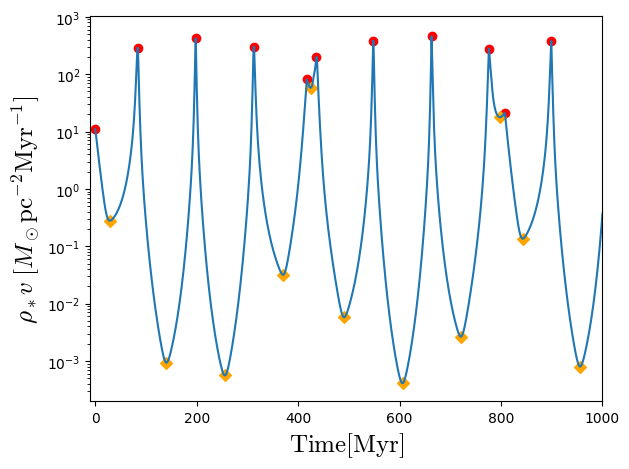

In [22]:
plt.rcParams["mathtext.fontset"] = "cm"

plt.semilogy(times, integrands)
plt.scatter(times[indices_peak], integrands[indices_peak], color = "red")
plt.scatter(times[indices_trough], integrands[indices_trough], color = "orange", marker="D")
plt.xlim(-10, 1000)
plt.xlabel(r"$\rm Time [Myr]$", fontsize=18)
plt.ylabel(r"$\rho_* v\ [M_\odot \mathrm{pc}^{-2} \mathrm{Myr}^{-1}]$", fontsize=18)
plt.tight_layout()
# plt.savefig("Integrands vs time plot - semilog y axis.pdf")
plt.show()

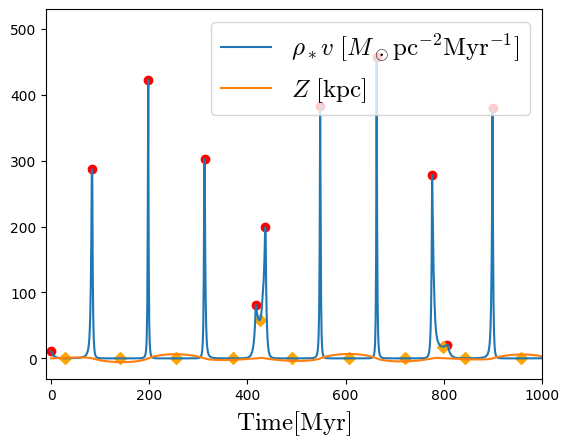

In [23]:
plt.plot(times[:1000], integrands[:1000], label=r"$\rho_* v\ [M_\odot \mathrm{pc}^{-2} \mathrm{Myr}^{-1}]$")
plt.plot(times[:1000], zs[:1000]/1000, label = r"$Z\ [\rm kpc]$")
plt.scatter(times[indices_peak], integrands[indices_peak], color = "red")
plt.scatter(times[indices_trough], integrands[indices_trough], color = "orange", marker="D")
plt.xlim(-10, 1000)
# plt.ylim(-10, 38)
plt.xlabel(r"$\rm Time [Myr]$", fontsize=18)
# plt.ylabel(r"$\rho_* v\ [M_\odot \mathrm{pc}^{-2} \mathrm{Myr}^{-1}]$", fontsize=18)
plt.legend(fontsize=18)
# plt.savefig("Integrands and z vs time plot - linear axis.pdf")
plt.show()